# Childhood Obesity: An Informative Dashboard

This interactive web app explores the causes, impacts, and potential solutions to childhood obesity using data and visualizations.



In [1]:
from IPython.display import Markdown, display, HTML

In [100]:
!pip install matplotlib

In [ ]:
!pip install --upgrade dash jupyter-dash ipywidgets

In [ ]:
!pip install ipywidgets pandas plotly qgrid

In [163]:
import sqlite3
import csv
import os

DB_PATH = "ChildObesity.db"
CSV_PATH = "cleaned_data.csv"

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Create raw table
cursor.execute('''
    DROP TABLE IF EXISTS survey_data;
''')
conn.commit()

cursor.execute('''
    
    CREATE TABLE IF NOT EXISTS survey_data (
        year_start INTEGER,
        year_end INTEGER,
        state_abbr TEXT,
        state TEXT,
        source TEXT,
        category TEXT,
        sub_category TEXT,
        indicator TEXT,
        data_value_unit TEXT,
        data_value_type TEXT,
        data_value REAL,
        data_value_alt REAL,
        low_confidence_limit REAL,
        high_confidence_limit REAL,
        sample_size INTEGER,
        gender TEXT,
        race TEXT,
        latitude REAL,
        longitude REAL,
        topic_code TEXT,
        question_code TEXT,
        stratification TEXT,
        class_id TEXT,
        topic_id TEXT,
        question_id TEXT,
        response_id TEXT,
        location_abbr TEXT
    )
''')
conn.commit()

# Load data from CSV if table empty
cursor.execute('SELECT COUNT(*) FROM survey_data')
count = cursor.fetchone()[0]

if count > 0:
    print(f"survey_data table already has {count} rows, skipping CSV load.")
else:
    if not os.path.exists(CSV_PATH):
        print(f"CSV file not found: {CSV_PATH}")
    else:
        with open(CSV_PATH, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header

            batch_size = 1000
            batch = []
            for i, row in enumerate(reader, 1):
                row = row[:27]
                batch.append(row)
                if i % batch_size == 0:
                    cursor.executemany('INSERT INTO survey_data VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', batch)
                    batch = []
            if batch:
                cursor.executemany('INSERT INTO survey_data VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', batch)
        conn.commit()

cursor.close()
conn.close()

In [165]:
import sqlite3

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

cursor.execute('CREATE INDEX IF NOT EXISTS idx_survey_cat ON survey_data(year_start, state_abbr, category)')
conn.commit()

cursor.execute('DROP TABLE IF EXISTS phys_act')
cursor.execute('DROP TABLE IF EXISTS sugar_drinks')
cursor.execute('DROP TABLE IF EXISTS television_viewing')
cursor.execute('DROP TABLE IF EXISTS fruits_vegetables')
cursor.execute('DROP TABLE IF EXISTS obesity')

cursor.execute('''
    CREATE TABLE phys_act AS
    SELECT year_start, state_abbr, state, category, topic_code, data_value, sample_size, category
    FROM survey_data WHERE category = 'Physical Activity'
''')

cursor.execute('''
    CREATE TABLE sugar_drinks AS
    SELECT year_start, state_abbr, data_value, topic_code, sample_size, category
    FROM survey_data WHERE category = 'Sugar Drinks'
''')

cursor.execute('''
    CREATE TABLE fruits_vegetables AS
    SELECT year_start, state_abbr, data_value, topic_code, sample_size, category
    FROM survey_data WHERE category = 'Fruits and Vegetables'
''')

cursor.execute('''
    CREATE TABLE obesity AS
    SELECT year_start, state_abbr, data_value, topic_code, sample_size, category
    FROM survey_data WHERE category = 'Obesity / Weight Status'
''')

conn.commit()

cursor.execute('DROP TABLE IF EXISTS survey_data_clean')

cursor.execute('''
    CREATE TABLE survey_data_clean AS
    SELECT
        pa.year_start AS YearStart,
        pa.state_abbr AS LocAbbr,
        pa.state AS LocDesc,
        pa.category AS Class,
        pa.topic_code AS Grade,
        pa.sample_size AS SampleSize,
        pa.category AS Category,
        pa.data_value AS PhysActVal,
        sd.data_value AS SugarDrnkVal,
        fv.data_value AS FrtAndVegVal,
        ob.data_value AS ObesityVal

    FROM phys_act pa
    LEFT JOIN sugar_drinks sd
        ON pa.year_start = sd.year_start
        AND pa.state_abbr = sd.state_abbr
        AND pa.topic_code = sd.topic_code
    LEFT JOIN fruits_vegetables fv
        ON pa.year_start = fv.year_start
        AND pa.state_abbr = fv.state_abbr
        AND pa.topic_code = fv.topic_code
    LEFT JOIN obesity ob
        ON pa.year_start = ob.year_start
        AND pa.state_abbr = ob.state_abbr
        AND pa.topic_code = ob.topic_code
''')
conn.commit()


cursor.close()
conn.close()

In [164]:
import sqlite3

CSV_PATH_D = "cleaned_data_demo.csv"

conn = sqlite3.connect("ChildObesity.db")
cursor = conn.cursor()

cursor.execute('DROP TABLE IF EXISTS ethnicity_obesity')
cursor.execute('''
    CREATE TABLE ethnicity_obesity (
        YearStart INTEGER,
        YearEnd INTEGER,
        LocationAbbr TEXT,
        LocationDesc TEXT,
        Datasource TEXT,
        Class TEXT,
        Topic TEXT,
        Question TEXT,
        Data_Value_Unit TEXT,
        Data_Value_Type TEXT,
        Data_Value REAL,
        Data_Value_Alt REAL,
        Data_Value_Footnote_Symbol REAL,
        Data_Value_Footnote,
        Low_Confidence_Limit REAL,
        High_Confidence_Limit REAL,
        Sample_Size INTEGER,
        Total INTEGER,
        Sex TEXT,
        Grade TEXT,
        Race TEXT,
        Latitude REAL,
        Longitude REAL,
        ClassID TEXT,
        TopicID TEXT,
        QuestionID TEXT,
        DataValueTypeID TEXT,
        LocationID REAL,
        StratificationCategory1 TEXT,
        Stratification1 TEXT,
        StratificationCategoryID1 TEXT,
        StratificationID1 TEXT  
    )
''')

conn.commit()

cursor.close()
conn.close()

In [51]:
import pandas as pd
import sqlite3

df = pd.read_csv(CSV_PATH_D)

df = df.where(pd.notnull(df), None)

conn = sqlite3.connect(DB_PATH)
df.to_sql("ethnicity_obesity", conn, if_exists='append', index=False)
conn.close()

In [162]:
#behavioral_prediction ML model training based on Public Data

import sqlite3
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Step 1: Load data from SQLite
conn = sqlite3.connect(DB_PATH)
query = '''
SELECT
    PhysActVal,
    SugarDrnkVal,
    FrtAndVegVal,
    ObesityVal,
    Grade,
    LocAbbr
FROM survey_data_clean
WHERE
    PhysActVal IS NOT NULL AND
    SugarDrnkVal IS NOT NULL AND
    FrtAndVegVal IS NOT NULL AND
    ObesityVal IS NOT NULL
'''
df = pd.read_sql_query(query, conn)
conn.close()

# Step 2: Define features and target
X = df.drop(columns=['ObesityVal'])
y = df['ObesityVal']

# Step 3: Preprocessing for categorical columns
categorical_features = ['Grade', 'LocAbbr']
numeric_features = ['PhysActVal', 'SugarDrnkVal', 'FrtAndVegVal']

# Step 4: Build pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # keep numeric features
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train model
model.fit(X_train, y_train)

# Step 7: Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
behavioral_prediction = y_pred

In [161]:
#demongraphic_prediction ML model training based on Public Data

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Load data from DB
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query("SELECT * FROM ethnicity_obesity", conn)
conn.close()

# Encode ethnicity to numeric
le = LabelEncoder()
df['ethnicity_encoded'] = le.fit_transform(df['Race'])

# Define features and target
X = df[['ethnicity_encoded']]
y = df['Data_Value']

# Train model
demo_model = LinearRegression()
demo_model.fit(X, y)

# Predict and evaluate
y_pred = demo_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

<function matplotlib.pyplot.show(close=None, block=None)>

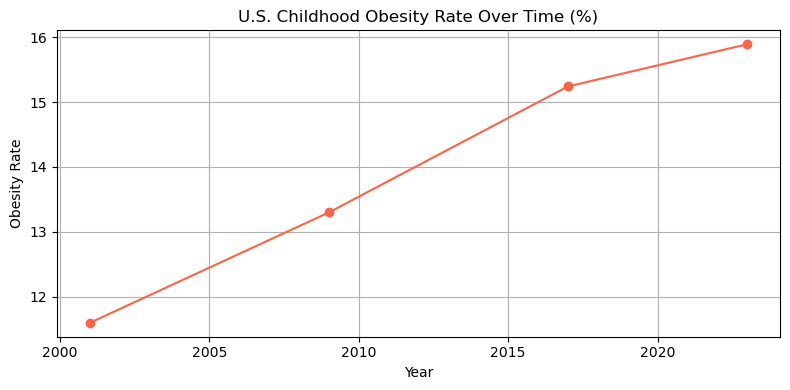

In [160]:
import matplotlib.pyplot as plt

years = [2001, 2009, 2017, 2023]
rates = [11.6, 13.3, 15.24, 15.89]

plt.figure(figsize=(8,4))
plt.plot(years, rates, marker='o', color='tomato')
plt.title("U.S. Childhood Obesity Rate Over Time (%)")
plt.xlabel("Year")
plt.ylabel("Obesity Rate")
plt.grid(True)
plt.tight_layout()
plt.show

# WHY IS CHILD OBESITY SO COMMON?

In [158]:
from IPython.display import display, HTML

display(HTML("""
<style>
  .image-container {
    position: relative;
    display: inline-block;
    width: 250px;
    height: 400px;
    margin: 10px;
    cursor: pointer;
    opacity: 0.7;
    transition: opacity 0.3s ease;
    border-radius: 8px;
    overflow: hidden;
  }
  .image-container:hover {
    opacity: 1;
  }
  .image-container img {
    width: 100%;
    height: 100%;
    object-fit: cover;
    display: block;
  }
  .image-text, .image-info {
    position: absolute;
    top: 50%;
    left: 50%;
    color: white;
    font-weight: bold;
    font-size: 24px;
    text-align: center;
    transform: translate(-50%, -50%);
    width: 90%;
    pointer-events: none;
    transition: opacity 0.3s ease;
    background-color: rgba(0, 0, 0, 0.4);
    padding: 10px;
    border-radius: 8px;
  }
  .image-info {
    display: none;
    background-color: rgba(173, 216, 230, 0.8); /* light blue */
    color: black;
    font-weight: normal;
    font-size: 16px;
    pointer-events: auto;
  }
</style>

<div class="image-container" onclick="toggleInfo(this)">
  <img src="./assets/diet.jpeg" alt="Poor Diet"/>
  <div class="image-text">Poor Diet</div>
  <div class="image-info">
    🍟 Poor diet contributes to weight gain.<br>
    Encourage fruits, vegetables, and whole foods over fast food.
  </div>
</div>

<div class="image-container" onclick="toggleInfo(this)">
  <img src="./assets/lackofexercise.jpeg" alt="Lack of Exercise"/>
  <div class="image-text">Lack of Exercise</div>
  <div class="image-info">
    🏃 Lack of physical activity increases obesity risk.<br>
    Promote at least 1 hour of physical activity per day.
  </div>
</div>

<div class="image-container" onclick="toggleInfo(this)">
  <img src="./assets/screen.jpeg" alt="Screen Time"/>
  <div class="image-text">Screen Time</div>
  <div class="image-info">
    📺 Excessive screen time limits movement and raises risk.<br>
    Limit screen time to 1-2 hours a day outside of schoolwork.
  </div>
</div>

<div class="image-container" onclick="toggleInfo(this)">
  <img src="./assets/socioeconomic.jpeg" alt="Socioeconomic Factors"/>
  <div class="image-text">Socioeconomic Factors</div>
  <div class="image-info">
    💰 Socioeconomic factors limit access to healthy options.<br>
    Support community programs and affordable access to fresh foods.
  </div>
</div>

<script>
  function toggleInfo(container) {
    const text = container.querySelector('.image-text');
    const info = container.querySelector('.image-info');
    if (info.style.display === 'block') {
      info.style.display = 'none';
      text.style.display = 'block';
    } else {
      info.style.display = 'block';
      text.style.display = 'none';
    }
  }
</script>
"""))


In [ ]:
import pandas as pd

data = {
    "Survey Period": ["2001-2002", "2003-2004", "2005-2006", "2007-2008", "2009-2010", "2011-2012", "2013-2014", "2015-2016", "2017-2018"],
    "Sample (n)": [4261, 3961, 4207, 3249, 3408, 3355, 3523, 3340, 2824],
    "Overweight (%)": [14.6, 16.5, 14.6, 14.8, 14.9, 14.9, 16.2, 16.6, 16.1],
    "Obesity (%)": [15.4, 17.1, 15.4, 16.8, 16.9, 16.9, 17.2, 18.5, 19.3],
    "Severe Obesity (%)": [5.2, 5.1, 4.7, 4.9, 5.6, 5.6, 6.0, 5.6, 6.1]
}

df = pd.DataFrame(data)

table_html = df.to_html(index=False, border=0)

# Remove the automatic <table> tag to insert custom caption and footer
# Split at first <table ...> to add custom caption and footer
table_start = table_html.find('<table')
table_end = table_html.find('>', table_start) + 1
table_close = table_html.rfind('</table>')

# Extract the inner part of the table (thead + tbody)
table_inner = table_html[table_end:table_close]

# Compose your custom full table with one caption and footer notes as <tfoot>
full_table = f"""
<table role="table" aria-label="Childhood Obesity Statistics from 2001 to 2018"
       style="border-collapse: collapse; width: 100%; font-family: Arial, sans-serif;">

    <caption style="caption-side: top; font-weight: bold; text-align: left; padding-bottom: 8px;">
        Childhood Obesity Statistics from 2001 to 2018 provided by CDC - Centers for Disease Control
    </caption>
    
    {table_inner}

    <tfoot>
        <tr>
            <td colspan="{len(df.columns)}" style="text-align:left; font-style: italic; padding-top: 10px;">
                Notes: Overweight is body mass index (BMI) at or above the 85th percentile and below the 95th percentile
                from the sex-specific BMI-for-age 2000 CDC Growth Charts. Obesity is BMI at or above the 95th percentile.
                Severe obesity is BMI at or above 120% of the 95th percentile.
            </td>
        </tr>
    </tfoot>
</table>
"""

display(HTML(full_table))

# State Specific Data Results For High School Students

In [157]:
import sqlite3
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Dropdown for selecting a US state abbreviation
state_dropdown = widgets.Dropdown(
    options=['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
             'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
             'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
             'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
             'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'],
    description='State:',
    value='MA'
)

# Output widget for displaying results
output = widgets.Output()

# Callback function to run query and display averages by grade
def display_data(change):
    state = state_dropdown.value
    with output:
        clear_output()
        try:
            conn = sqlite3.connect("ChildObesity.db")
            query = '''
                SELECT 
                    YearStart AS Year,
                    Grade,
                    AVG(PhysActVal) AS Avg_Physical_Activity_Perc,
                    AVG(SugarDrnkVal) AS Avg_Consmd_Sugar_Drinks_Perc,
                    AVG(FrtAndVegVal) AS Avg_Fruit_Veg_Consmd_Perc,
                    AVG(ObesityVal) AS Avg_Obesity_Rt
                FROM survey_data_clean
                WHERE LocAbbr = ?
                GROUP BY Grade, YearStart
                ORDER BY YearStart, Grade DESC
            '''
            df = pd.read_sql_query(query, conn, params=(state,))
            conn.close()

            if df.empty:
                print(f"No data found for state: {state}")
            else:
                display(df)

        except Exception as e:
            print(f"Error: {e}")

# Register the callback
state_dropdown.observe(display_data, names='value')

# Display the UI
display(state_dropdown, output)
display_data(None)  # Show initial display


Dropdown(description='State:', index=20, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', …

Output()

In [154]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# --- Define UI elements ---
height_text = widgets.FloatText(
    value=170.0,
    description='Height (in cm): ',
    step=0.1
)

weight_text = widgets.FloatText(
    value=70.0,
    description='Weight (in kg): ',
    step=0.1
)

phys_act_slider = widgets.FloatSlider(value=3.0, min=1, max=5, step=0.1, description='Physical Activity:')
sugar_slider = widgets.FloatSlider(value=2.5, min=1, max=5, step=0.1, description='Sugar Drinks:')
fruit_veg_slider = widgets.FloatSlider(value=3.5, min=1, max=5, step=0.1, description='Fruits/Veggies:')
grade_dropdown = widgets.Dropdown(options=['9', '10', '11', '12'], value='10', description='Grade:')
state_dropdown = widgets.Dropdown(options=['TX', 'CA', 'NY', 'FL', 'IL', 'MA', 'SC'], value='TX', description='State:')
ethnicity_radio = widgets.RadioButtons(options=['Hispanic', 'Non-Hispanic White', 'Non-Hispanic Black', 'Asian'], value='Hispanic', description='Ethnicity:')
region_map = {
    "Northeast": ["CT", "ME", "MA", "NH", "RI", "VT", "NY", "PA"],
    "Midwest": ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"],
    "South": ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "DC", "WV", "AL", "KY", "MS", "TN", "AR", "LA", "OK", "TX"],
    "West": ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY", "AK", "CA", "HI", "OR", "WA"]
}
predict_button = widgets.Button(description='Predict Obesity Risk')
output = widgets.Output()

# --- Display UI ---
display(widgets.VBox([
    height_text,
    weight_text,
    phys_act_slider,
    sugar_slider,
    fruit_veg_slider,
    grade_dropdown,
    state_dropdown,
    ethnicity_radio,
    predict_button,
    output
]))
# --- BMI Calculator ---
def calculate_bmi(weight_kg, height_cm):
    height_m = height_cm / 100  # convert to meters
    if height_m <= 0:
        return 0, "Invalid"
    bmi = weight_kg / (height_m * height_m)
    # Determine range
    return round(bmi, 1)

def bmi_cat(bmi):
    if bmi < 18.5:
        category = "Underweight"
        return category
    elif bmi >= 18.5 and bmi <= 24.9:
        category = "Healthy"
        return category
    elif bmi>= 25 and bmi <= 29.9:
        category = "Overweight"
        return category
    elif bmi > 30:
        category = "Obese"
        return category
        
# --- Prediction Function ---
def predict_obesity_risk(b=None):
    with output:
        clear_output(wait=True) 

        # --- Gather input ---
        phys_val = phys_act_slider.value
        sugar_val = sugar_slider.value
        fruit_val = fruit_veg_slider.value
        grade = grade_dropdown.value
        state = state_dropdown.value
        ethnicity = ethnicity_radio.value
        weight = weight_text.value
        height = height_text.value
        
        region = None
        for reg, states in region_map.items():
            if state in states:
                region = reg
                break
        region_modifier = {
            "Northeast": 0.02,
            "Midwest": -0.05,
            "South": -0.03,
            "West": 0.02,
        }.get(region, 0)     
        
        bmi_value = calculate_bmi(weight, height)
        bmi_category = bmi_cat(bmi_value)
        bmi_modifier = {
            "Underweight": -5,
            "Healthy": 0,
            "Overweight": 30,
            "Obese": 60
        }[bmi_category]
        
        # --- Behavioral Prediction ---
        behavior_input = pd.DataFrame([{
            'PhysActVal': phys_val,
            'SugarDrnkVal': sugar_val,
            'FrtAndVegVal': fruit_val,
            'Grade': grade,
            'LocAbbr': state
        }])
        behavioral_pred = model.predict(behavior_input)[0]
        if phys_val > 3:
            behavioral_pred -= behavioral_pred * 0.5
        if fruit_val > 3: 
            behavioral_pred -= behavioral_pred * 0.5
        if sugar_val > 3:
            behavioral_pred += behavioral_pred * 0.5
            
        # --- Demographic Prediction ---
        demo_input = pd.DataFrame([{'Race': ethnicity}])
        demo_input['ethnicity_encoded'] = le.transform(demo_input['Race'])
        demographic_pred = demo_model.predict(demo_input[['ethnicity_encoded']])[0]
        demographic_pred += region_modifier * demographic_pred
        # --- Combine ---
        final_pred = (behavioral_pred) + (demographic_pred) + (bmi_modifier)
        obese_percent = min(max(final_pred, 0), 100)
        not_obese_percent = 100 - obese_percent

        # --- Plot Pie Chart ---
        labels = ['Obese', 'Not Obese']
        sizes = [obese_percent, not_obese_percent]
        colors = ['#ff6666', '#66b3ff']

        fig, ax = plt.subplots()
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
        ax.axis('equal')
        plt.title('Predicted Obesity Risk')
        plt.show()
        plt.close(fig)  # Ensure backend doesn't retain figure

# --- Link button once ---
predict_button.on_click(predict_obesity_risk)


## Resources
- [CDC on Childhood Obesity](https://www.cdc.gov/obesity/childhood/)
- [WHO Guidelines](https://www.who.int/news-room/fact-sheets/detail/obesity-and-overweight)

## Conclusion
Combating childhood obesity requires awareness, healthy habits, and community support. Please do not hesitate to reach out to 
official authorities if you, or someone you know, might be developing obesity.

The Obesity Society:

Cell #: 301-563-6526

E-mail: editorial@obesity.org

